# **Random Forest**

## **1. Importación Librerías y Configuración**

In [ ]:
# IMPORTACIONES Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import joblib
import kagglehub
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files

MODEL_OUTPUT = "random_forest_v3.joblib"
DATASET_REF = "spmv1980/hackaton-2025-equipo-71"

## **2. Descarga del Set de Datos**

In [ ]:
# DESCARGA DEL DATASET
print(f"⬇️ Descargando dataset desde Kaggle ({DATASET_REF})...")
path = kagglehub.dataset_download(DATASET_REF)
csv_path = os.path.join(path, "df_procesado_todas las aerolneas.csv")

if os.path.exists(csv_path):
    print(f"📂 Dataset localizado en: {csv_path}")
else:
    print(f"❌ Error: No se encontró el archivo csv en {path}")


⬇️ Descargando dataset desde Kaggle (spmv1980/hackaton-2025-equipo-71)...
Using Colab cache for faster access to the 'hackaton-2025-equipo-71' dataset.
📂 Dataset localizado en: /kaggle/input/hackaton-2025-equipo-71/df_procesado_todas las aerolneas.csv


## **3. Feature Engineering**

In [ ]:
# FEATURE ENGINEERING
def feature_engineering(df):
    """
    Genera características temporales y cíclicas.
    """
    df = df.copy()
    # Asegurar tipo datetime
    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
        df['mes'] = df['FL_DATE'].dt.month
        df['dia_semana'] = df['FL_DATE'].dt.dayofweek

        # Features cíclicas para capturar estacionalidad (Enero ≈ Diciembre)
        df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
        df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

        # Features cíclicas para días de la semana (Domingo ≈ Lunes)
        df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
        df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

        # Indicador de fin de semana
        df['es_fin_de_semana'] = (df['dia_semana'] >= 5).astype(int)
    return df

## **4. Entrenamiento**

In [ ]:
# ENTRENAMIENTO
print("\n🚀 INICIANDO ENTRENAMIENTO DEL MODELO V3 (SIN DATA LEAKAGE)")
print("-" * 60)

# Cargar datos
print("📖 Leyendo CSV (esto puede tardar unos segundos)...")
df = pd.read_csv(csv_path)

# Aplicar transformaciones
print("⚙️ Generando features temporales...")
df = feature_engineering(df)

# Codificar categóricas
print("🔠 Codificando variables categóricas (LabelEncoder)...")
encoders = {}
cat_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'TAIL_NUM']
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        # Convertir a str para evitar errores con mixtos/nulos
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le

features = [
    'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_de_semana',
    'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
    'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM'
]

# Verificar que existan todas las columnas
for f in features:
    if f not in df.columns:
        print(f"⚠️ Advertencia: Columna {f} no encontrada. Se llenará con ceros.")
        df[f] = 0

print(f"📋 Features seleccionadas ({len(features)}):")
print(f"   {features}")
print("   ✅ 'DEP_TIME' ha sido excluida correctamente.")

X = df[features]
y = df['DEP_DEL15']

# Split
print("✂️ Dividiendo Train/Test (70/30)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Configuración del Random Forest (Mejores hiperparámetros encontrados)
rf_params = {
    'n_estimators': 98,
    'max_depth': 22,
    'max_features': 'sqrt',
    'min_samples_leaf': 16,
    'min_samples_split': 10,
    'class_weight': 'balanced',  # Maneja el desbalance de clases (80/20)
    'n_jobs': -1,
    'random_state': 42
}

print(f"🧠 Entrenando Random Forest... {rf_params}")
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

# Metricas rápidas
train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print(f"📊 Accuracy Train: {train_acc:.4f}")
print(f"📊 Accuracy Test:  {test_acc:.4f}")


🚀 INICIANDO ENTRENAMIENTO DEL MODELO V3 (SIN DATA LEAKAGE)
------------------------------------------------------------
📖 Leyendo CSV (esto puede tardar unos segundos)...
⚙️ Generando features temporales...
🔠 Codificando variables categóricas (LabelEncoder)...
📋 Features seleccionadas (15):
   ['mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_de_semana', 'MONTH', 'QUARTER', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'TAIL_NUM']
   ✅ 'DEP_TIME' ha sido excluida correctamente.
✂️ Dividiendo Train/Test (70/30)...
🧠 Entrenando Random Forest... {'n_estimators': 98, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 16, 'min_samples_split': 10, 'class_weight': 'balanced', 'n_jobs': -1, 'random_state': 42}
📊 Accuracy Train: 0.7740
📊 Accuracy Test:  0.7257


## **5. Métricas de Evaluación**

In [ ]:
# Métricas de evaluación

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Predicciones
y_pred = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)[:, 1]

print("📊 Accuracy:", accuracy_score(y_test, y_pred))

print("\n🧮 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("📈 ROC AUC:", roc_auc_score(y_test, y_pred_prob))

📊 Accuracy: 0.7257411606375062

🧮 Matriz de confusión:
[[1262714  391375]
 [ 177598  242897]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82   1654089
         1.0       0.38      0.58      0.46    420495

    accuracy                           0.73   2074584
   macro avg       0.63      0.67      0.64   2074584
weighted avg       0.78      0.73      0.74   2074584

📈 ROC AUC: 0.7359053592633594


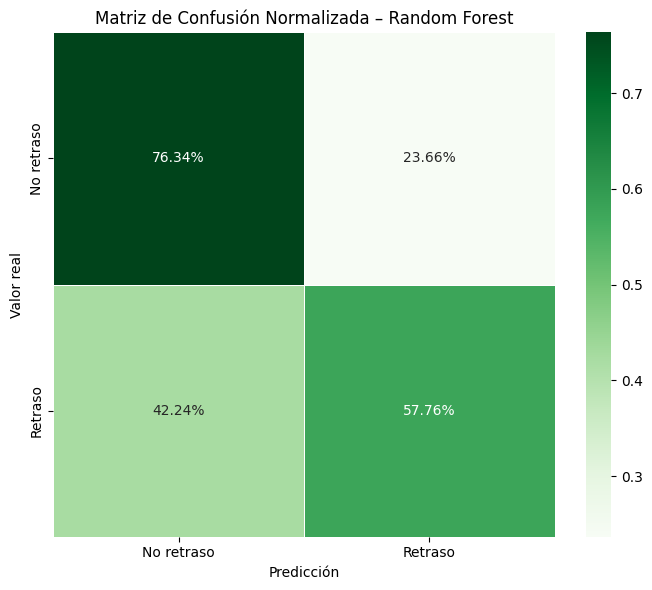

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Etiquetas de las clases (ajusta si usas otras)
labels = ['No retraso', 'Retraso']

cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    linewidths=0.5
)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión Normalizada – Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# Importancia de variables
import pandas as pd

importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': rf.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias

,Variable,Importancia
12,CRS_DEP_TIME,0.219095
13,CRS_ARR_TIME,0.188780
14,TAIL_NUM,0.102788
7,DAY_OF_MONTH,0.092500
10,ORIGIN,0.091299
11,DEST,0.083104
9,OP_UNIQUE_CARRIER,0.068186
1,mes_cos,0.038096
5,MONTH,0.029356
2,dia_semana_sin,0.023872


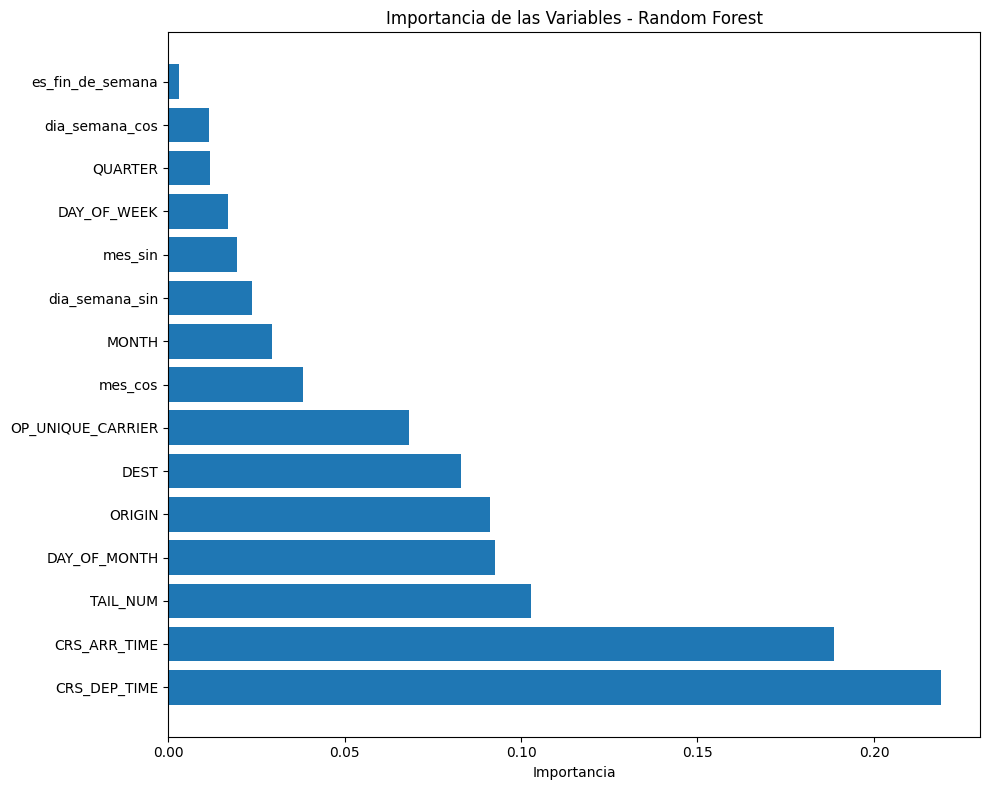

In [ ]:
# Graficar
plt.figure(figsize=(10, 8))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Variables - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

In [ ]:
# 1. Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred) #best_rf1

In [ ]:
# 2. Calcular AUC roc_auc = roc_auc_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_pred)

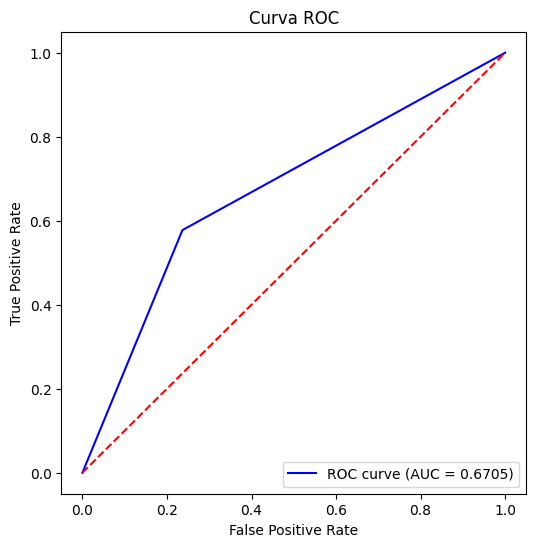

In [ ]:
# 3. Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # línea aleatoria
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

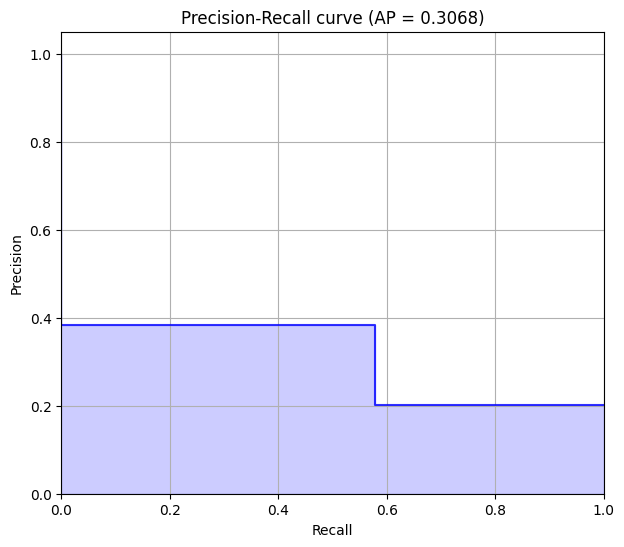

In [ ]:
# Curva Precision Recall
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_true: etiquetas 0/1; y_scores: probabilidades para la clase positiva
# Ejemplo:
# y_true = ...
# y_scores = model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.figure(figsize=(7,6))
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (AP = {ap:.4f})')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

In [ ]:
# 6. GUARDADO Y EXPORTACIÓN DEL MODELO
# Guardar artefacto completo
artifact = {
    "model": rf,
    "encoders": encoders,
    "features": features,
    "feature_engineering": feature_engineering
}

print(f"💾 Guardando artefacto: {MODEL_OUTPUT}")
joblib.dump(artifact, MODEL_OUTPUT, compress=3)

# Descarga automática
print("⬇️ Descargando archivo a tu computadora...")
try:
    files.download(MODEL_OUTPUT)
    print("✅ ¡Proceso completado! Entrega el archivo .joblib al desarrollador.")
except Exception as e:
    print(f"⚠️ Error al intentar descargar automáticamente: {e}")
    print(f"   Por favor descarga manualmente el archivo '{MODEL_OUTPUT}' del panel de archivos.")